## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [60]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
display('Site visiting', 
      data.groupby('group')['user_id'].agg('count')
      )

mask = (data['purchase'] == 1)

display('Purchase count', 
      data[mask].groupby('group')['purchase'].agg('count')
      )

display('Total amount', 
      round((data[mask].groupby('group')['price'].agg('sum')/1e6), 2)
      )

'Site visiting'

group
A    147202
B    147276
Name: user_id, dtype: int64

'Purchase count'

group
A    17723
B    17514
Name: purchase, dtype: int64

'Total amount'

group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [8]:
A_users = set(data[data['group'] == 'A']['user_id'])
B_users = set(data[data['group'] == 'B']['user_id'])
dupl_users = A_users.intersection(B_users)
print(len(dupl_users))
updated_data = data[data['user_id'].apply(lambda x: x not in dupl_users)]

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [ ]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

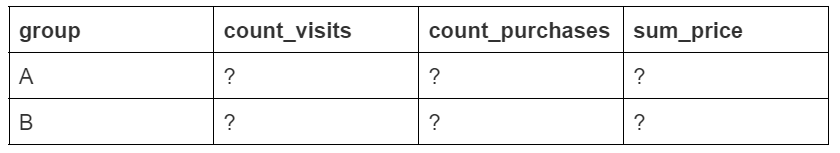
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [20]:
ab_data = updated_data.groupby('group')[
    'user_id', 'purchase', 'price'
    ].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}
          )
ab_data.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}, inplace=True)
display(ab_data)

/tmp/ipykernel_63645/1569870278.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ab_data = updated_data.groupby('group')[


,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

In [24]:
n_a_users = ab_data.loc['A']['count_visits']
n_b_users = ab_data.loc['B']['count_visits']
delta = round((n_b_users - n_a_users)/n_a_users*100, 2)
print(delta, '%')

0.05 %


Построенная таблица показывает, что количество посещений в выборках сопоставимо. Разница 5 сотых процента. Выборки сбалансированны.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [25]:
ab_data['conversion'] =  ab_data['count_purchases']/ab_data['count_visits']*100
ab_data['mean_check'] =  ab_data['sum_price']/ab_data['count_purchases']
display(ab_data)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Из таблицы видим, что конверсия выше в контрольной выборке, однако средний чек больше в тестовой. Необходимо дальнейшее исследование. Так как на данном этапе нельзя сделать однозначный вывод по эффективности того или иного варианта.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

purchase
group price           
A     10000       5182
      60000       5271
      100000      1832
      150000      3478
      200000      1724
B     10000       5201
      60000       1730
      100000      5227
      150000      3438
      200000      1694

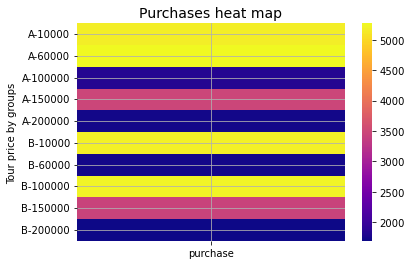

In [57]:
pivot = updated_data[updated_data['price'] > 0].groupby(['group', 'price']).agg({'purchase': 'sum'})
heatmap = sns.heatmap(data=pivot, cmap='plasma')
heatmap.set_title('Purchases heat map', fontsize=14);
heatmap.set_ylabel('Tour price by groups');
heatmap.grid()
display(pivot)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Для участников группы А покупательская способность выше по турам стоимостью 60 000 руб. Для участников группы В туры стоимостью 100 000 руб более продаваемы. 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [70]:
new_data.head()

count_visits  count_purchases  sum_price  conversion  \
group date                                                               
A     2021-01-02          2894              362   29720000   12.508639   
      2021-01-03          6684              760   62640000   11.370437   
      2021-01-04          6655              810   64970000   12.171300   
      2021-01-05          6538              801   65710000   12.251453   
      2021-01-06          6684              778   64440000   11.639737   

                    mean_check  
group date                      
A     2021-01-02  82099.447514  
      2021-01-03  82421.052632  
      2021-01-04  80209.876543  
      2021-01-05  82034.956305  
      2021-01-06  82827.763496

In [79]:
new_data = updated_data.groupby(
    ['group','date']
    ).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

new_data.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}, inplace=True)
new_data['conversion'] =  new_data['count_purchases']/new_data['count_visits']*100
new_data['mean_check'] =  new_data['sum_price']/new_data['count_purchases']

cnv_a = new_data.loc[('A', '2021-01-03')]['conversion']
cnv_b = new_data.loc[('B', '2021-01-03')]['conversion']

print('Convertion in group A at January 3rd:', round(cnv_a, 2))
print('Convertion in group B at January 3rd:', round(cnv_b, 2))

avg_check_a = new_data.loc[('A', '2021-01-03')]['mean_check']
avg_check_b = new_data.loc[('B', '2021-01-03')]['mean_check']

print('Average check in group A at January 3rd:', round(avg_check_a))
print('Average check in group B at January 3rd:', round(avg_check_b))

Convertion in group A at January 3rd: 11.34
Convertion in group B at January 3rd: 11.39
Average check in group A at January 3rd: 82888
Average check in group B at January 3rd: 87480


In [77]:
new_data.head()

count_visits  count_purchases  sum_price  conversion  \
group date                                                               
A     2021-01-02          2894              362   29720000   12.508639   
      2021-01-03          6684              760   62640000   11.370437   
      2021-01-04          6655              810   64970000   12.171300   
      2021-01-05          6538              801   65710000   12.251453   
      2021-01-06          6684              778   64440000   11.639737   

                    mean_check  
group date                      
A     2021-01-02  82099.447514  
      2021-01-03  82421.052632  
      2021-01-04  80209.876543  
      2021-01-05  82034.956305  
      2021-01-06  82827.763496

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [ ]:
# ваш код здесь

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [ ]:
# ваш код здесь

ваши выводы здесь

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь

Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 